<a href="https://colab.research.google.com/github/omareyoussef/456project/blob/main/CECS456_Project_(VGG16).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install tensorflow keras numpy pandas matplotlib scikit-learn kaggle

from google.colab import files
files.upload()

# Select the kaggle.json file

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d alessiocorrado99/animals10

!unzip animals10.zip -d animals10

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

data_dir = 'animals10/raw-img'

animal_mapping = {
    'cane': 'dog',
    'cavallo': 'horse',
    'elefante': 'elephant',
    'farfalla': 'butterfly',
    'gallina': 'chicken',
    'gatto': 'cat',
    'mucca': 'cow',
    'pecora': 'sheep',
    'ragno': 'spider',
    'scoiattolo': 'squirrel'
}

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.15
)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.15)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = val_datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 22257 images belonging to 10 classes.
Found 3922 images belonging to 10 classes.
Found 26179 images belonging to 10 classes.


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# Load the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in base_model.layers[-4:]:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(10, activation='softmax')(x)

transfer_model = Model(inputs=base_model.input, outputs=predictions)

transfer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:

transfer_history = transfer_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)


Epoch 1/10
696/696 [==============================] - 187s 247ms/step - loss: 1.9881 - accuracy: 0.2822 - val_loss: 1.6706 - val_accuracy: 0.4510
Epoch 2/10
696/696 [==============================] - 168s 242ms/step - loss: 1.2288 - accuracy: 0.5736 - val_loss: 0.8425 - val_accuracy: 0.7024
Epoch 3/10
696/696 [==============================] - 168s 241ms/step - loss: 0.8373 - accuracy: 0.7223 - val_loss: 0.6687 - val_accuracy: 0.7743
Epoch 4/10
696/696 [==============================] - 170s 244ms/step - loss: 0.5936 - accuracy: 0.8117 - val_loss: 0.5463 - val_accuracy: 0.8261
Epoch 5/10
696/696 [==============================] - 171s 245ms/step - loss: 0.4755 - accuracy: 0.8507 - val_loss: 0.3816 - val_accuracy: 0.8705
Epoch 6/10
696/696 [==============================] - 173s 248ms/step - loss: 0.4085 - accuracy: 0.8763 - val_loss: 0.3148 - val_accuracy: 0.8939
Epoch 7/10
696/696 [==============================] - 170s 244ms/step - loss: 0.3598 - accuracy: 0.8904 - val_loss: 0.3595 -

123/123 [==============================] - 6s 45ms/step - loss: 0.2970 - accuracy: 0.9115
Validation Loss: 0.296983540058136
Validation Accuracy: 0.9115247130393982
819/819 [==============================] - 48s 59ms/step - loss: 0.1760 - accuracy: 0.9461
Test Loss: 0.1759776920080185
Test Accuracy: 0.9460636377334595


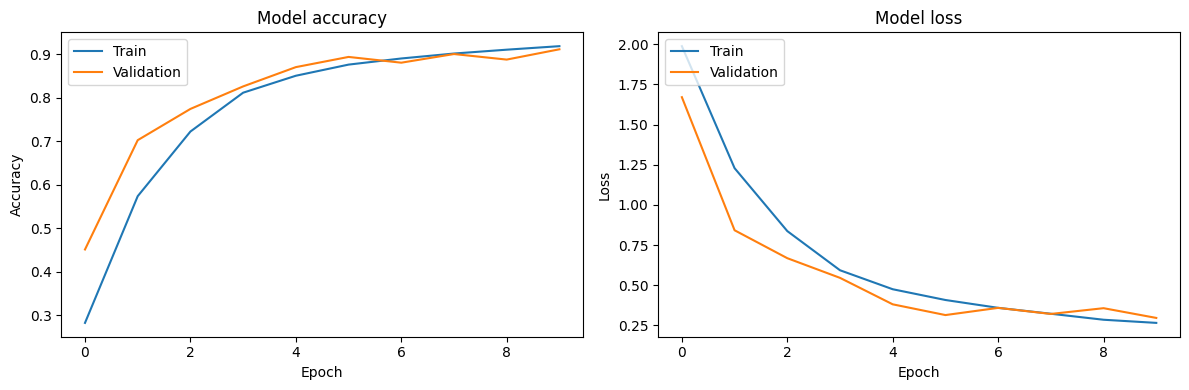

In [ ]:

val_loss, val_accuracy = transfer_model.evaluate(val_generator)

print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

test_loss, test_accuracy = transfer_model.evaluate(test_generator)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(transfer_history.history['accuracy'])
plt.plot(transfer_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(transfer_history.history['loss'])
plt.plot(transfer_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 21ms/step


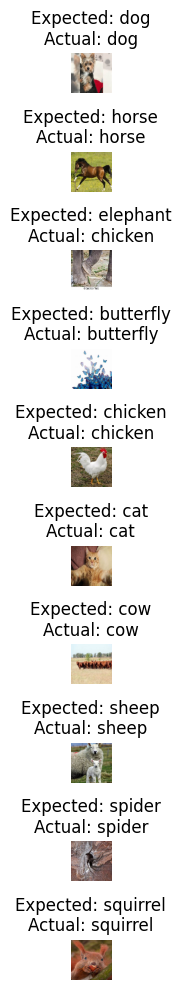

In [ ]:

class_names = [animal_mapping[cls] for cls in list(train_generator.class_indices.keys())]

num_classes = len(class_names)
num_examples = 10
samples_per_class = num_examples // num_classes

plt.figure(figsize=(20, 10))

sampled_images = {cls: 0 for cls in range(num_classes)}

for test_images, test_labels in test_generator:
    for i in range(len(test_images)):
        class_idx = np.argmax(test_labels[i])
        if sampled_images[class_idx] < samples_per_class:
            plt.subplot(num_classes, samples_per_class, class_idx * samples_per_class + sampled_images[class_idx] + 1)
            plt.imshow(test_images[i])
            expected_label = class_names[class_idx]
            actual_label = class_names[np.argmax(transfer_model.predict(test_images[i:i+1])[0])]
            plt.title(f"Expected: {expected_label}\nActual: {actual_label}")
            plt.axis('off')
            sampled_images[class_idx] += 1
        if all(count == samples_per_class for count in sampled_images.values()):
            break
    if all(count == samples_per_class for count in sampled_images.values()):
        break

plt.tight_layout()
plt.show()
